# Developing Causal Impact analysis with Deep Learning models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
from parse_cesar1 import get_timestep_tuples
import pickle

In [7]:
from pyprocessta.causalimpact import _select_unrelated_x
from pyprocessta.model.tcn import transform_data, run_model


In [8]:
from darts import TimeSeries
import pandas as pd
from definitions import TARGETS
import matplotlib.pyplot as plt

MEAS_COLUMNS = [
    "TI-19",
    "FI-16",
    "TI-33",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-241",
    "valve-position-12",  # dry-bed
    "FI-38",  # stripper
    "PI-28",  # stripper
    "TI-28",  # stripper
    "FI-20",
    "FI-30",
    "TI-3",
    "FI-19",
    "FI-211",
    "FI-11",
    "TI-30",
    "PI-30",
    "TI-1213",
    "TI-4",
    "FI-23",
    "delta_t",
]

In [9]:
df = pd.read_pickle('detrended.pkl')
df = df.dropna()
df['delta_t'] = df['TI-35'] - df["TI-4"]
MEAS_COLUMNS.append('delta_t')

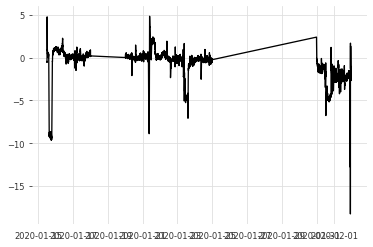

In [10]:
plt.plot(df['delta_t'])

In [24]:
with open('step_times.pkl', 'rb') as handle:
    times = pickle.load(handle)

In [32]:
def get_causalimpact_splits(x, y, day, times, df): 
    a, b = get_timestep_tuples(df, times, day)
 
    x_way_before, x_after = x.split_before(a[1])
    y_way_before, y_after = y.split_before(pd.Timestamp(a[1]))

    _, x_before = x_way_before.split_before(a[0])
    _, y_before = y_way_before.split_before(a[0])

    x_during, x_test = x_after.split_before(b[1])
    y_during, y_test = y_after.split_before(b[1])

    return (x_before, y_before), (x_during, y_during), (x_test, y_test)

    
    

In [26]:
for i in range(10):
    a, b = get_timestep_tuples(df, times, i)
    
    print(i, a, b)
    assert a[0] < a[1]

0 [Timestamp('2020-01-15 11:42:01', freq='2T'), Timestamp('2020-01-15 14:10:01', freq='2T')] [Timestamp('2020-01-15 14:10:01', freq='2T'), Timestamp('2020-01-15 18:30:01', freq='2T')]
1 [Timestamp('2020-01-15 18:30:01', freq='2T'), Timestamp('2020-01-16 09:10:01', freq='2T')] [Timestamp('2020-01-16 09:10:01', freq='2T'), Timestamp('2020-01-16 13:10:01', freq='2T')]
2 [Timestamp('2020-01-16 13:10:01', freq='2T'), Timestamp('2020-01-17 08:54:01', freq='2T')] [Timestamp('2020-01-17 08:54:01', freq='2T'), Timestamp('2020-01-17 13:54:01', freq='2T')]
3 [Timestamp('2020-01-17 13:54:01', freq='2T'), Timestamp('2020-01-20 08:50:01', freq='2T')] [Timestamp('2020-01-20 08:50:01', freq='2T'), Timestamp('2020-01-20 13:50:01', freq='2T')]
4 [Timestamp('2020-01-20 13:50:01', freq='2T'), Timestamp('2020-01-21 11:40:01', freq='2T')] [Timestamp('2020-01-21 11:40:01', freq='2T'), Timestamp('2020-01-21 16:50:01', freq='2T')]
5 [Timestamp('2020-01-21 16:50:01', freq='2T'), Timestamp('2020-01-22 09:00:01',

In [27]:
times[7]

{'start': datetime.datetime(2020, 1, 24, 8, 25),
 'end': datetime.datetime(2020, 1, 24, 13, 35)}

In [28]:
times[8]

{'start': datetime.datetime(2020, 1, 31, 12, 40),
 'end': datetime.datetime(2020, 1, 31, 19, 40)}

In [29]:
df.index

DatetimeIndex(['2020-01-15 11:42:01', '2020-01-15 11:44:01',
               '2020-01-15 11:46:01', '2020-01-15 11:48:01',
               '2020-01-15 11:50:01', '2020-01-15 11:52:01',
               '2020-01-15 11:54:01', '2020-01-15 11:56:01',
               '2020-01-15 11:58:01', '2020-01-15 12:00:01',
               ...
               '2020-02-01 23:40:01', '2020-02-01 23:42:01',
               '2020-02-01 23:44:01', '2020-02-01 23:46:01',
               '2020-02-01 23:48:01', '2020-02-01 23:50:01',
               '2020-02-01 23:52:01', '2020-02-01 23:54:01',
               '2020-02-01 23:56:01', '2020-02-01 23:58:01'],
              dtype='datetime64[ns]', length=12609, freq='2T')

In [30]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [33]:
causalimpact_models = {}

for day in range(10):

    before, during, after = get_causalimpact_splits(x, y, day, times, df)
    train_tuple, test_tuple, scalers = transform_data(before, [during, after])
    model = run_model(train_tuple)

    causalimpact_models[day] = {
        'before': before, 
        'during': during,
        'after': after, 
        'model': model
    }


[2021-04-30 14:42:31,793] INFO | darts.models.torch_forecasting_model | Train dataset contains 65 samples.
[2021-04-30 14:42:31,793] INFO | darts.models.torch_forecasting_model | Train dataset contains 65 samples.


(130, 24) (130, 4)
(12405, 24) (12405, 4)


[2021-04-30 14:42:56,603] INFO | darts.models.torch_forecasting_model | Train dataset contains 432 samples.
[2021-04-30 14:42:56,603] INFO | darts.models.torch_forecasting_model | Train dataset contains 432 samples.


(120, 24) (120, 4)
(11845, 24) (11845, 4)


[2021-04-30 14:43:33,385] INFO | darts.models.torch_forecasting_model | Train dataset contains 584 samples.
[2021-04-30 14:43:33,385] INFO | darts.models.torch_forecasting_model | Train dataset contains 584 samples.


(150, 24) (150, 4)
(11103, 24) (11103, 4)


[2021-04-30 14:44:29,815] INFO | darts.models.torch_forecasting_model | Train dataset contains 2000 samples.
[2021-04-30 14:44:29,815] INFO | darts.models.torch_forecasting_model | Train dataset contains 2000 samples.


(150, 24) (150, 4)
(8945, 24) (8945, 4)


[2021-04-30 14:46:48,835] INFO | darts.models.torch_forecasting_model | Train dataset contains 647 samples.
[2021-04-30 14:46:48,835] INFO | darts.models.torch_forecasting_model | Train dataset contains 647 samples.


(155, 24) (155, 4)
(8135, 24) (8135, 4)


[2021-04-30 14:47:48,300] INFO | darts.models.torch_forecasting_model | Train dataset contains 477 samples.
[2021-04-30 14:47:48,300] INFO | darts.models.torch_forecasting_model | Train dataset contains 477 samples.


(155, 24) (155, 4)
(7495, 24) (7495, 4)


[2021-04-30 14:48:36,426] INFO | darts.models.torch_forecasting_model | Train dataset contains 562 samples.
[2021-04-30 14:48:36,426] INFO | darts.models.torch_forecasting_model | Train dataset contains 562 samples.


(155, 24) (155, 4)
(6770, 24) (6770, 4)


[2021-04-30 14:49:30,410] INFO | darts.models.torch_forecasting_model | Train dataset contains 534 samples.
[2021-04-30 14:49:30,410] INFO | darts.models.torch_forecasting_model | Train dataset contains 534 samples.


(155, 24) (155, 4)
(6073, 24) (6073, 4)


[2021-04-30 14:50:22,791] INFO | darts.models.torch_forecasting_model | Train dataset contains 5005 samples.
[2021-04-30 14:50:22,791] INFO | darts.models.torch_forecasting_model | Train dataset contains 5005 samples.


(210, 24) (210, 4)
(850, 24) (850, 4)


[2021-04-30 14:55:57,598] INFO | darts.models.torch_forecasting_model | Train dataset contains 397 samples.
[2021-04-30 14:55:57,598] INFO | darts.models.torch_forecasting_model | Train dataset contains 397 samples.


(215, 24) (215, 4)
(230, 24) (230, 4)


In [150]:
for day, values in causalimpact_models.items():
    before_predictions = []
    during_predictions = []
    after_predictions = []

    for i in range(200):
        x_test, y_test = values['before']
        before_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))
        
        x_test, y_test = values['during']
        during_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))

        x_test, y_test = values['after']
        after_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))

    causalimpact_models[day]['before_predictions'] = before_predictions
    causalimpact_models[day]['during_predictions'] = during_predictions
    causalimpact_models[day]['after_predictions'] = after_predictions
        

In [ ]:
with open('causalimpact.pkl', 'wb') as handle: 
    pickle.dump(causalimpact_models, handle)

In [ ]:
test

In [145]:
x_test, y_test = test_tuple[1]  
backtest_cov = model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.1,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False)

0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inpla

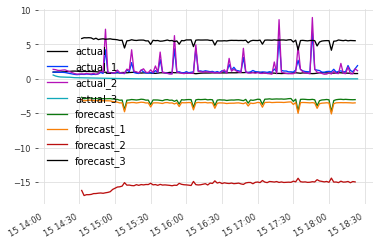

In [100]:
y_test.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend()